In [1]:
import array
import matplotlib.pyplot as plot

# Connect to Rigol scope

In [ ]:
# pip install pyvisa pyvisa-py
import pyvisa

rm = pyvisa.ResourceManager('@py')
inst = rm.open_resource("TCPIP::192.168.86.230::INSTR")

q = inst.query
w = inst.write

q("*IDN?")

# Configure trigger and start single acquisition

In [ ]:
w(':ACQ:MEMD LONG') # Long memory type
w(':CHAN1:COUP DC') # DC coupling
w(':CHAN1:DISP ON') # Channel 1 on
w(':CHAN2:DISP OFF') # Channel 2 off
w(':CHAN1:SCAL 1') # Channel 1 vertical scale 1 volts
w(':CHAN1:OFFS -4') # Channel 1 vertical offset -4 volts
w(':TIM:SCAL .02') # 20ms time interval
w(':TIM:OFFS -.08') # Offset time -80 ms (center at -80 ms), trigger to the right

w(':TRIG:EDGE:SOUR CHAN1') # Edge-trigger from channel 1
w(':TRIG:EDGE:COUP DC') # DC trigger coupling
w(':TRIG:EDGE:SLOP POS') # Trigger on positive edge
w(':TRIG:EDGE:LEV 7.0') # Trigger at 7.0 volts
#w(':TRIGger:SWEep NORMal')
w(":SING")


# Trigger the scope
Now place a black stone at (16, 4) position. The scope should be triggered.

# Search for the start of the polling loop
Loop starts with a negative pulse of 2.8 V and 10 ms wide. Stone position is marked by a runt of 3.8 V and 1 ms wide. The negative spikes indicate when the X location is shifted to the next line.

In [ ]:
q(":SEARch:STATe?")
w(":SEARch:STATe 1")
q(":SEARch:STATe?")
w(":SEARch:MODE PULS")
w(":SEARch:PULSe:POLarity NEGative")
w(":SEARch:PULSe:SOURce CHAN1")
q(":SEARch:PULSe:QUAL?")
w(":SEARch:PULSe:THReshold 3.5")
w(":SEARch:PULSe:LWIDth 0.005")


# Search result
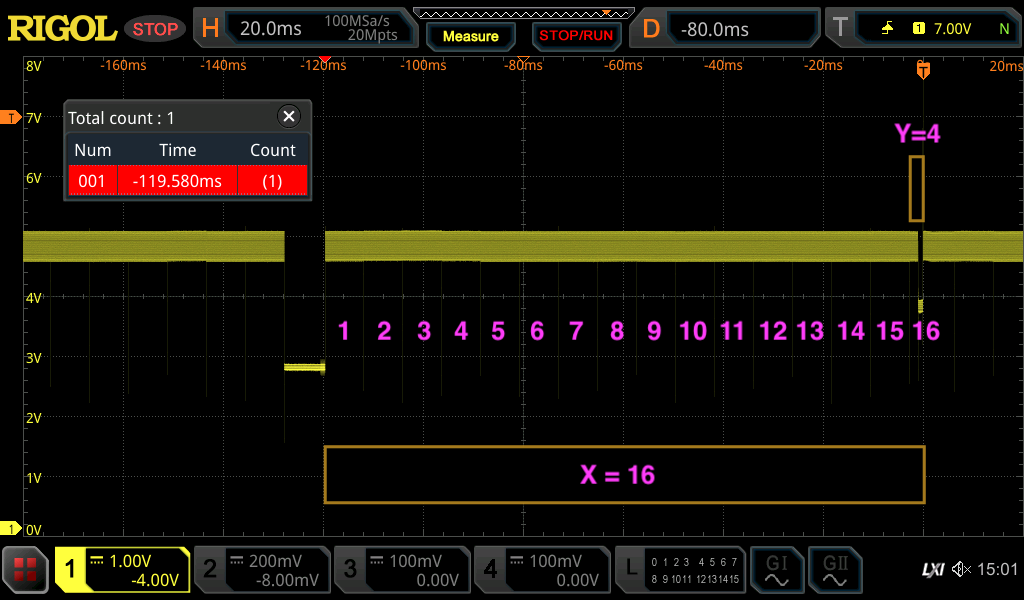

In [ ]:
print("Found anything? ", q(":SEAR:COUNT?"))
print("Current search index? ", q(":SEAR:EVEN?"))
start = float(q(":SEAR:VAL? 0").strip())
start = round(start, 6)
print("Loop start location: ", start)
w(":WAV:DATA?")
rawdata = inst.read_raw()
d = array.array('B', rawdata[10:])
#print(d)
plot.plot(d)



The plotted data should look like this. Same shape as the oscilloscope screenshot.

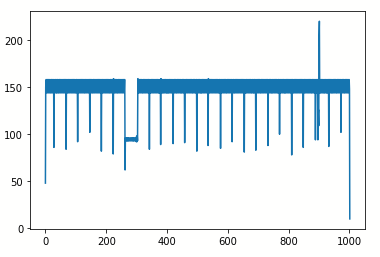

# Search for spikes and the runt
Right rising edge of the runt is at time 0.

In [30]:
w(":SEARch:MODE EDGe")
w(":SEARch:EDGe:POLarity POSitive")
w(":SEARch:EDGe:SOURce CHAN1")
w(":SEARch:EDGe:THReshold 3.5")
edge_cnt = int(q(":SEAR:COUNT?"))
print("Count: ", edge_cnt)
print("Current index: ", q(":SEAR:EVEN?"))
print("Value of 1st occurrence:", q(":SEAR:VAL? 0"))


count:  26
current index,  0

value of 1st occurrance: -1.745260E-1



# Search result
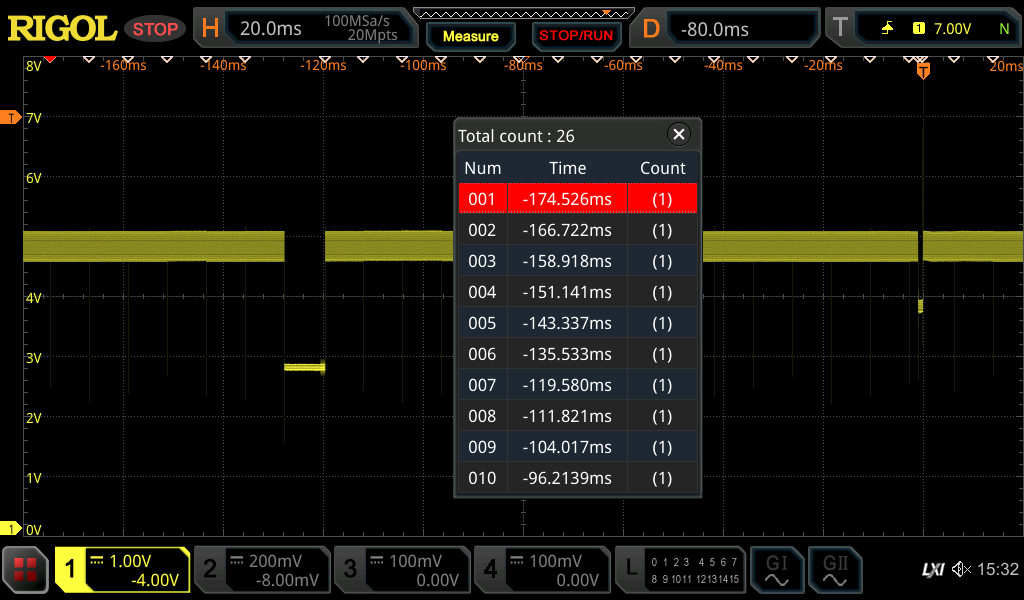

# Calculate (X, Y) position
Only count spikes between loops start and the runt at time 0.

In [29]:
bars = []
for i in range(edge_cnt):
    t = float(q(":SEARch:VAL? {}".format(i)))
    t = round(t, 6)
    if t > start and t < 0:
        bars += [t]

X = len(bars)

Y = (bars[-1] - bars[-2] + 0.0002) / 0.0004
print ('({}, {})'.format(X, int(Y)))


(16, 4)
